In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve, classification_report 
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import time

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['hiring-dataset.csv']


In [2]:
def confusion_matrix_plt(y_test_cm, y_pred_cm):
    y_test_legit = sum(y_test_cm==0)
    y_test_fraud = sum(y_test_cm==1)
    
    accuracy_cm = accuracy_score(y_test_cm, y_pred_cm)
    cfn_matrix = confusion_matrix(y_test_cm,y_pred_cm)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap=plt.cm.Blues,linewidths=0.5,annot=True,ax=ax)
    ax.set_title("Confusion Matrix \n Accuracy: %.2f%%" % (accuracy_cm * 100.0), fontsize=14)
    ax.set_xticklabels(['Rejected', 'Hired'], fontsize=10, rotation=90)
    ax.set_yticklabels(['Rejected', 'Hired'], fontsize=10, rotation=360)
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap=plt.cm.Blues,linewidths=0.5,annot=True,ax=ax)
    ax.set_title("Normalized Confusion Matrix \n Accuracy: %.2f%%" % (accuracy_cm * 100.0), fontsize=14)
    ax.set_xticklabels(['Rejected', 'Hired'], fontsize=10, rotation=90)
    ax.set_yticklabels(['Rejected', 'Hired'], fontsize=10, rotation=360)
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test_cm, y_pred_cm))


In [3]:
df = pd.read_csv('../input/hiring-dataset.csv')
df.head()

,Job Schedule,Job Type,Location,Job Field,Application Source Type,Candidate Is Internal,Ethnicity Type,Candiate is disabled,Age (Years),iq,ambition,interpersonal,creativity,fluid_iq,achievement,achievement_striving,agreeableness,benevolence,cog_flex,collectivism,core_self_evaluation,curiosity,extraversion,neuroticism,openness,self_discipline,total score,Candidate Gender,Manager Gender,Recruiter Gender,Hired
0,Full-time,Standard,South Africa,Finance,Job Board,No,Undisclosed,Not Specified,43.0,-0.373554,0.968764,1.437621,1.432227,-0.379863,0.368982,0.246642,0.381664,0.045286,0.581696,0.246568,0.466697,0.637316,0.823203,-0.983899,0.606679,0.364939,5.0,F,M,F,Yes
1,Full-time,Internship,Austria,Internship,Other,Yes,Undisclosed,Not Specified,24.0,1.402516,-0.148778,0.685506,1.597418,1.426203,0.171713,-0.134151,-0.327894,-0.168573,0.580583,-0.017783,0.424842,0.802357,1.031612,-0.686828,0.654594,-0.431925,76.0,M,F,F,Yes
2,Full-time,Internship,United Kingdom,Brand,Other,No,Undisclosed,Not Specified,NaN,0.735062,1.604615,1.577899,1.570545,0.747477,0.196642,0.375426,0.361094,0.388138,0.643205,0.087637,0.781607,0.698272,0.797492,-1.171691,0.660890,0.628726,10.0,F,F,F,Yes
3,Full-time,Standard,United States,Finance,Our Web Site,Yes,Black or African American (not Hispanic or Lat...,Disability - No,39.0,-1.014683,-1.408723,2.457776,1.552636,-1.031820,0.439912,-0.555909,0.540158,0.629094,0.590203,0.192195,-0.617201,0.735825,0.931424,-1.976413,0.653253,-0.395827,73.0,F,F,M,Yes
4,Full-time,Standard,United States,Sales,Our Web Site,Yes,Hispanic or Latino,Disability - No,40.0,-0.619255,1.654636,2.557612,1.479359,-0.629713,0.592665,0.757627,0.518452,0.446853,0.664151,0.171627,0.586404,0.709703,1.304844,-1.964447,0.520276,0.493658,1.0,M,M,F,Yes


At average 1.7035% applicants are hired
No     85168
Yes     1476
Name: Hired, dtype: int64


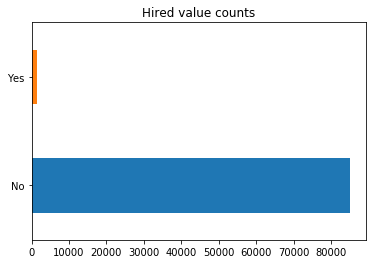

In [4]:
print(f"At average {df['Hired'].value_counts()[1]/len(df) * 100:.4f}% applicants are hired")
df['Hired'].value_counts().plot(kind='barh', title='Hired value counts');
print(df['Hired'].value_counts())

## deal with categorial features and missing values

In [5]:
map_dict = {'No': 0, 'Yes': 1}
df['Hired'] = df['Hired'].apply(lambda x: map_dict[str(x)])

map_dict = {'F': 0, 'M': 1, 'nan': 2}
df['Candidate Gender'] = df['Candidate Gender'].apply(lambda x: map_dict[str(x)])
df['Manager Gender'] = df['Manager Gender'].apply(lambda x: map_dict[str(x)])
df['Recruiter Gender'] = df['Recruiter Gender'].apply(lambda x: map_dict[str(x)])

map_dict = {'nan': 0, 'Full-time': 1, 'Part-time': 2}
df['Job Schedule'] = df['Job Schedule'].apply(lambda x: map_dict[str(x)])

map_dict = {'nan': 0, 'Standard': 1, 'Internship': 2, 'Temporary Work': 3, 'Graduate Job': 4}
df['Job Type'] = df['Job Type'].apply(lambda x: map_dict[str(x)])

map_dict = {'nan': 0, 'United States': 1, 'Austria': 2, 'United Kingdom': 3, 'Australia': 4, 'Canada': 5, 'New Zealand': 6, 'South Africa': 7} 
df['Location'] = df['Location'].apply(lambda x: map_dict[str(x)])

map_dict = {'nan': 0, 'Sales': 1, 'Operations (Production, Supply Chain, etc.)': 2, 'Field Marketing': 3, 'Media': 4,
            'Sports': 5, 'Brand': 6, 'Finance': 7, 'Off Premise Sales': 8, 'Administration': 9, 'Graduate Program': 10,
            'Student Brand Manager': 11, 'Culture': 12, 'On Premise Sales': 13, 'Human Resources': 14, 'IT': 15, 
            'Internship': 16, 'Distribution': 17, 'Communications': 18, 'Legal': 19, 'Student Marketeer': 20}   
df['Job Field'] = df['Job Field'].apply(lambda x: map_dict[str(x)])

map_dict = {'nan': 0, 'Our Web Site': 1, 'Job Board': 2, 'Social Network': 3, 'Other': 4, 'Taleo Performance': 5, 
            'Not Specified': 0, 'News Group': 6, 'Mailing List': 7, 'Professional Associations': 8, 'Newspapers': 9, 'Direct Sourcing': 10} 
df['Application Source Type'] = df['Application Source Type'].apply(lambda x: map_dict[str(x)])

map_dict = {'No': 0, 'Yes': 1, 'nan': 2}
df['Candidate Is Internal'] = df['Candidate Is Internal'].apply(lambda x: map_dict[str(x)])

map_dict = {'nan': 0, 'Undisclosed': 0, 'White (not Hispanic or Latino)': 1, 'Hispanic or Latino': 2, 'Black or African American (not Hispanic or Latino)': 3, 
            'Asian (not Hispanic or Latino)': 4, 'American Indian or Alaska Native (not Hispanic or Latino)': 5, 'Native Hawaiian or Other Pacific Islander (not Hispanic or Latino)': 6} 
df['Ethnicity Type'] = df['Ethnicity Type'].apply(lambda x: map_dict[str(x)])

map_dict = {'Disability - No': 0, 'Disability - Yes': 1, 'Not Specified': 2, 'Undisclosed': 2, 'nan': 2}
df['Candiate is disabled'] = df['Candiate is disabled'].apply(lambda x: map_dict[str(x)])

At average 0.4882% applicants are hired
0    26945
1      423
Name: Hired, dtype: int64


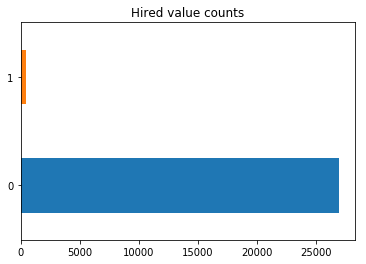

In [6]:
data_with_scores = df.dropna(subset=["iq", "ambition", "interpersonal", "creativity", "fluid_iq", "achievement", 
                                                   "achievement_striving", "agreeableness", "benevolence", "cog_flex", 
                                                   "collectivism", "core_self_evaluation", "curiosity", "extraversion", 
                                                   "neuroticism", "openness", "self_discipline", "total score"])
print(f"At average {data_with_scores['Hired'].value_counts()[1]/len(df) * 100:.4f}% applicants are hired")
print(data_with_scores['Hired'].value_counts())
data_with_scores['Hired'].value_counts().plot(kind='barh', title='Hired value counts');

In [7]:
protected_class = ['Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Candidate Is Internal', 'Ethnicity Type', 'Candiate is disabled', 'Age (Years)', 
                   'Candidate Gender', 'Manager Gender', 'Recruiter Gender', 'Hired']

data_with_scores.head()

,Job Schedule,Job Type,Location,Job Field,Application Source Type,Candidate Is Internal,Ethnicity Type,Candiate is disabled,Age (Years),iq,ambition,interpersonal,creativity,fluid_iq,achievement,achievement_striving,agreeableness,benevolence,cog_flex,collectivism,core_self_evaluation,curiosity,extraversion,neuroticism,openness,self_discipline,total score,Candidate Gender,Manager Gender,Recruiter Gender,Hired
0,1,1,7,7,2,0,0,2,43.0,-0.373554,0.968764,1.437621,1.432227,-0.379863,0.368982,0.246642,0.381664,0.045286,0.581696,0.246568,0.466697,0.637316,0.823203,-0.983899,0.606679,0.364939,5.0,0,1,0,1
1,1,2,2,16,4,1,0,2,24.0,1.402516,-0.148778,0.685506,1.597418,1.426203,0.171713,-0.134151,-0.327894,-0.168573,0.580583,-0.017783,0.424842,0.802357,1.031612,-0.686828,0.654594,-0.431925,76.0,1,0,0,1
2,1,2,3,6,4,0,0,2,NaN,0.735062,1.604615,1.577899,1.570545,0.747477,0.196642,0.375426,0.361094,0.388138,0.643205,0.087637,0.781607,0.698272,0.797492,-1.171691,0.660890,0.628726,10.0,0,0,0,1
3,1,1,1,7,1,1,3,0,39.0,-1.014683,-1.408723,2.457776,1.552636,-1.031820,0.439912,-0.555909,0.540158,0.629094,0.590203,0.192195,-0.617201,0.735825,0.931424,-1.976413,0.653253,-0.395827,73.0,0,0,1,1
4,1,1,1,1,1,1,2,0,40.0,-0.619255,1.654636,2.557612,1.479359,-0.629713,0.592665,0.757627,0.518452,0.446853,0.664151,0.171627,0.586404,0.709703,1.304844,-1.964447,0.520276,0.493658,1.0,1,1,0,1


## split into training and test set

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data_with_scores
y = data_with_scores['Hired']

Xtrain_, Xtest_, original_ytrain, original_ytest = train_test_split(X, y, test_size = 0.3, random_state = 15)

original_Xtrain = Xtrain_.drop(protected_class, axis=1)
original_Xtest = Xtest_.drop(protected_class, axis=1)

Xtrain_['Hired'] = original_ytrain
Xtest_['Hired'] = original_ytest
Xtrain_.to_csv('training_df.csv')
Xtest_.to_csv('test_df.csv')

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Label Distributions: 

[0.98454873 0.01545127]
[0.98453294 0.01546706]


## visualize the training set with PCA transformation

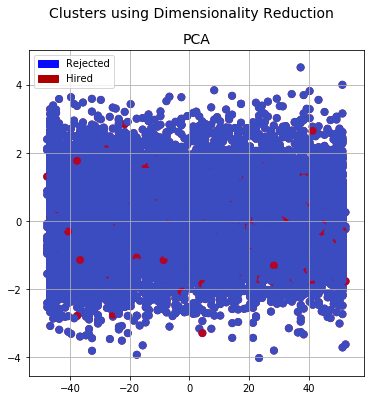

In [9]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches


X_reduced_pca = PCA(n_components=2, random_state=15).fit_transform(original_Xtrain.values)

f, ax = plt.subplots(figsize=(6,6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='Rejected')
red_patch = mpatches.Patch(color='#AF0000', label='Hired')
# PCA scatter plot
ax.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(original_ytrain == 0), cmap='coolwarm', label='Rejected', linewidths=2)
ax.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(original_ytrain == 1), cmap='coolwarm', label='Hired', linewidths=2)
ax.set_title('PCA', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

plt.show()

The two classes are not separable.

## perform prediction with plain logistic regression model without preprocessing
Although the accuracy is high, the model is useless since it simply predicts all the candidates as rejected. The high accuracy rate is just an illusion.

In [10]:
model = LogisticRegression()
model.fit(original_Xtrain, original_ytrain)
y_pred = model.predict(original_Xtest)

accuracy = accuracy_score(original_ytest, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.45%


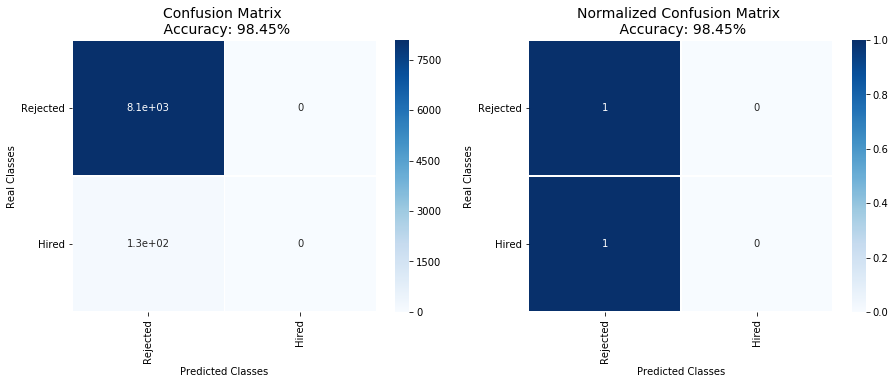

---Classification Report---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8084
           1       0.00      0.00      0.00       127

    accuracy                           0.98      8211
   macro avg       0.49      0.50      0.50      8211
weighted avg       0.97      0.98      0.98      8211



In [11]:
confusion_matrix_plt(original_ytest, y_pred)

# apply resampling techniques with imlearn
### visualize the training set with PCA transformation in 2D

Using TensorFlow backend.


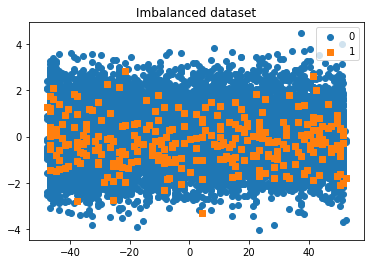

In [12]:
import imblearn

X = original_Xtrain
y = original_ytrain

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset')

### Random Undersample

In [13]:
X = original_Xtrain
y = original_ytrain

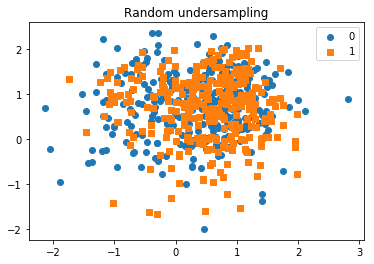

In [14]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

plot_2d_space(X_rus, y_rus, 'Random undersampling')

Text(0, 0.5, 'count')

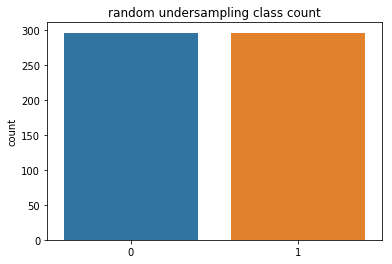

In [15]:
sns.barplot(y=[sum(y_rus==0), sum(y_rus==0)], x=[0,1])
plt.title('random undersampling class count')
plt.ylabel('count')

### Random Oversample

18565 new random picked points


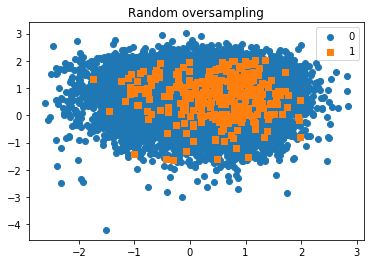

In [16]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random oversampling')

Text(0, 0.5, 'count')

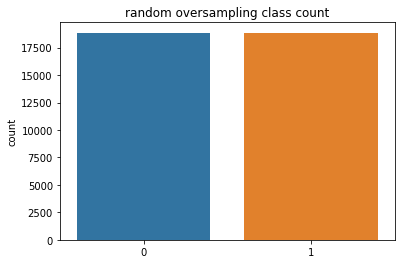

In [17]:
sns.barplot(y=[sum(y_ros==0), sum(y_ros==0)], x=[0,1])
plt.title('random oversampling class count')
plt.ylabel('count')

### ClusterCentroids

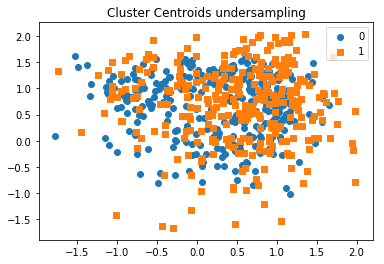

In [18]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={0: sum(y==1)})
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids undersampling')

Text(0, 0.5, 'count')

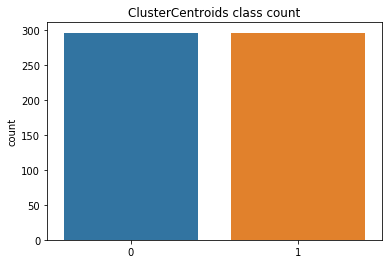

In [19]:
sns.barplot(y=[sum(y_cc==0), sum(y_cc==0)], x=[0,1])
plt.title('ClusterCentroids class count')
plt.ylabel('count')

### SMOTE

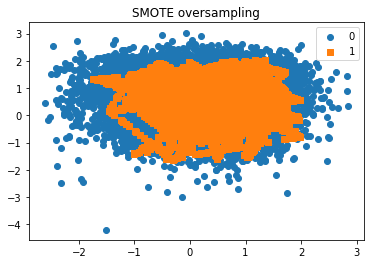

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE oversampling')

Text(0, 0.5, 'count')

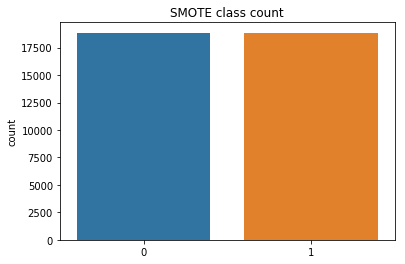

In [21]:
sns.barplot(y=[sum(y_sm==0), sum(y_sm==0)], x=[0,1])
plt.title('SMOTE class count')
plt.ylabel('count')

## learn a new classifier with data after resampling

In [22]:
def simple_logistic_regression(Xtrain, ytrain, Xtest, ytest):

    model = LogisticRegression()
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)

    accuracy = accuracy_score(ytest, y_pred)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))

    conf_mat = confusion_matrix(y_true=ytest, y_pred=y_pred)
    #print('Confusion matrix:\n', conf_mat)
    
    return accuracy, conf_mat

accuracy_rus, conf_mat_rus = simple_logistic_regression(X_rus, y_rus, original_Xtest, original_ytest)
accuracy_ros, conf_mat_ros = simple_logistic_regression(X_ros, y_ros, original_Xtest, original_ytest)
accuracy_cc, conf_mat_cc = simple_logistic_regression(X_cc, y_cc, original_Xtest, original_ytest)
accuracy_sm, conf_mat_sm = simple_logistic_regression(X_sm, y_sm, original_Xtest, original_ytest)

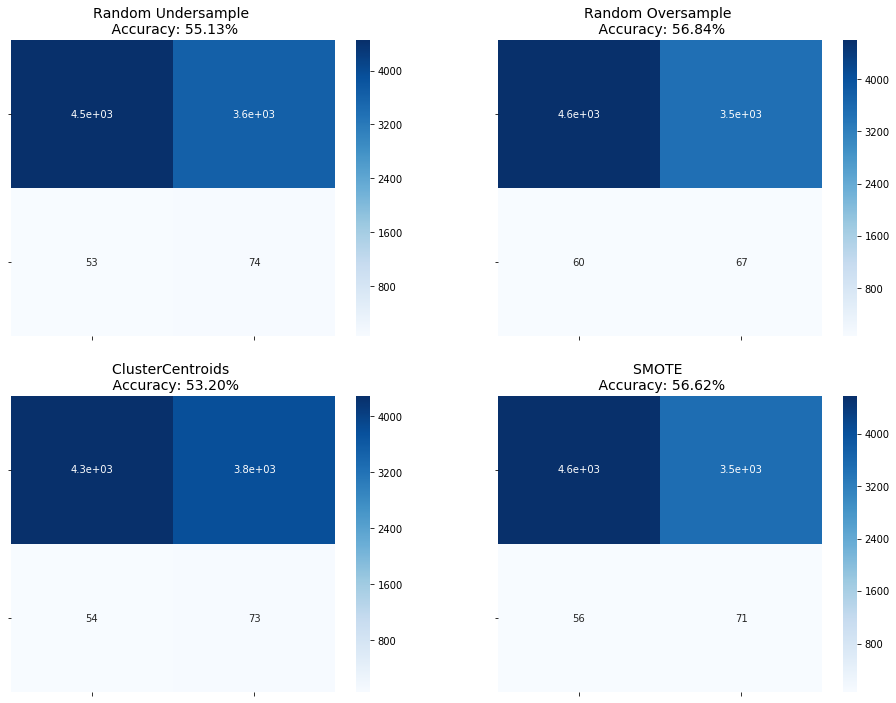

In [23]:
fig, ax = plt.subplots(2, 2,figsize=(16,12))

sns.heatmap(conf_mat_rus, ax=ax[0][0], annot=True, cmap=plt.cm.Blues)
ax[0][0].set_title("Random Undersample \n Accuracy: %.2f%%" % (accuracy_rus.mean() * 100.0), fontsize=14)
ax[0][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(conf_mat_ros, ax=ax[0][1], annot=True, cmap=plt.cm.Blues)
ax[0][1].set_title("Random Oversample \n Accuracy: %.2f%%" % (accuracy_ros.mean() * 100.0), fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(conf_mat_cc, ax=ax[1][0], annot=True, cmap=plt.cm.Blues)
ax[1][0].set_title("ClusterCentroids \n Accuracy: %.2f%%" % (accuracy_cc.mean() * 100.0), fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(conf_mat_sm, ax=ax[1][1], annot=True, cmap=plt.cm.Blues)
ax[1][1].set_title("SMOTE \n Accuracy: %.2f%%" % (accuracy_sm.mean() * 100.0), fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

### overfitting during cross validation

## Logistic Regression

In [24]:
# log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# log_reg_cc = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)
# log_reg_cc = log_reg_cc.fit(X_cc, y_cc)

# print('The best parameters are', log_reg_cc.best_params_)

# # The best parameters are {'penalty': 'l2', 'C': 10}

In [25]:
log_reg_cc = LogisticRegression(penalty='l2', C=10)
log_reg_cc = log_reg_cc.fit(X_cc, y_cc)

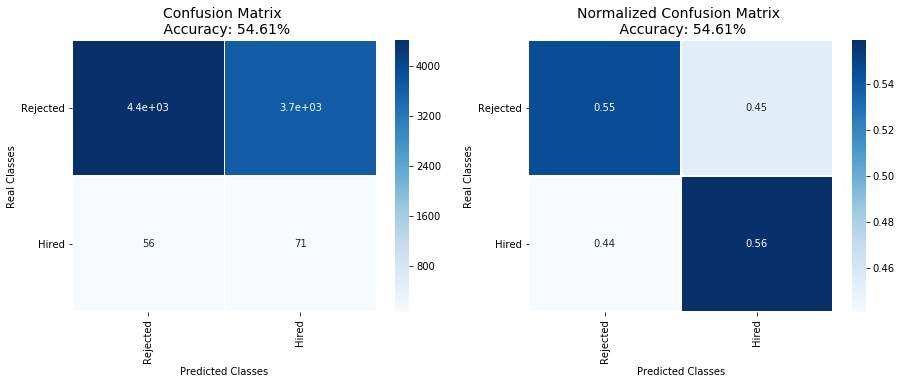

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.55      0.70      8084
           1       0.02      0.56      0.04       127

    accuracy                           0.55      8211
   macro avg       0.50      0.55      0.37      8211
weighted avg       0.97      0.55      0.69      8211



In [26]:
cc_prediction_lr = log_reg_cc.predict(original_Xtest)
confusion_matrix_plt(original_ytest, cc_prediction_lr)

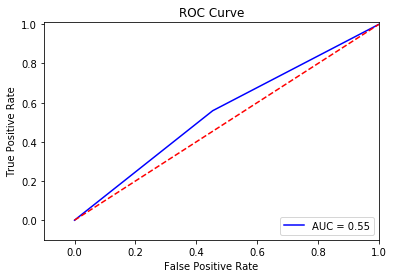

In [27]:
fpr, tpr, thresholds = roc_curve(original_ytest, cc_prediction_lr)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
Xtest_lr = Xtest_.copy()
Xtest_lr['Pred'] = cc_prediction_lr
Xtest_lr.to_csv('prediction_lr.csv')

## SVM

In [29]:
# print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
# print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# svc_params = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

# svc_cc = RandomizedSearchCV(SVC(), svc_params, n_iter=4)
# svc_cc = svc_cc.fit(X_cc, y_cc)

# print('The best parameters are', svc_cc.best_params_)

In [30]:
svc_cc = SVC(kernel='poly', C=100)
svc_cc = svc_cc.fit(X_cc, y_cc)

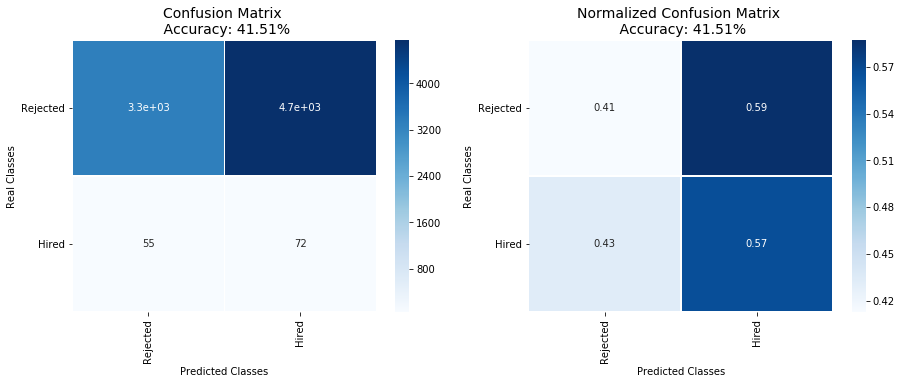

---Classification Report---
              precision    recall  f1-score   support

           0       0.98      0.41      0.58      8084
           1       0.01      0.57      0.03       127

    accuracy                           0.42      8211
   macro avg       0.50      0.49      0.31      8211
weighted avg       0.97      0.42      0.57      8211



In [31]:
cc_prediction_svc = svc_cc.predict(original_Xtest)
confusion_matrix_plt(original_ytest, cc_prediction_svc)

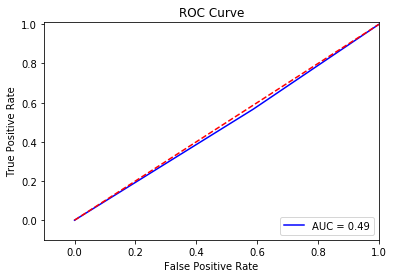

In [32]:
fpr, tpr, thresholds = roc_curve(original_ytest, cc_prediction_svc)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
Xtest_svc = Xtest_.copy()
Xtest_svc['Pred'] = cc_prediction_svc
Xtest_svc.to_csv('prediction_svc.csv')

# Cost Sensitive Models

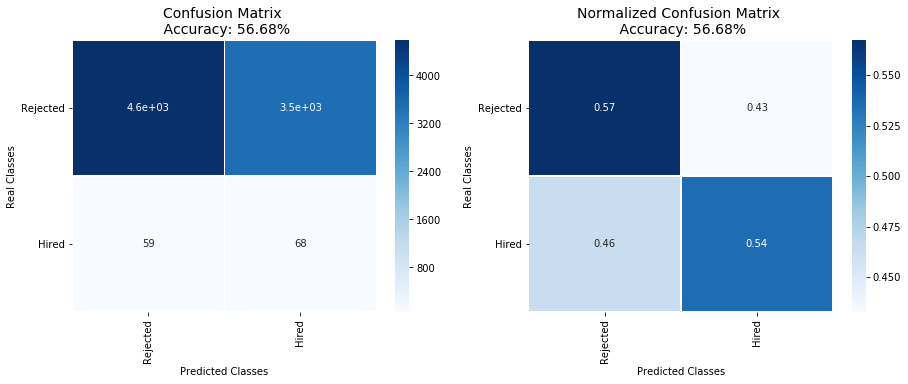

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.57      0.72      8084
           1       0.02      0.54      0.04       127

    accuracy                           0.57      8211
   macro avg       0.50      0.55      0.38      8211
weighted avg       0.97      0.57      0.71      8211



In [34]:
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(original_Xtrain, original_ytrain)

cs_pred_lr = lr_model.predict(original_Xtest)
confusion_matrix_plt(original_ytest, cs_pred_lr)

In [35]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

log_reg_cs = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)
log_reg_cs = log_reg_cs.fit(original_Xtrain, original_ytrain)

print('The best parameters are', log_reg_cs.best_params_)

The best parameters are {'penalty': 'l1', 'C': 0.01}


---Weight 50 for the minority class---


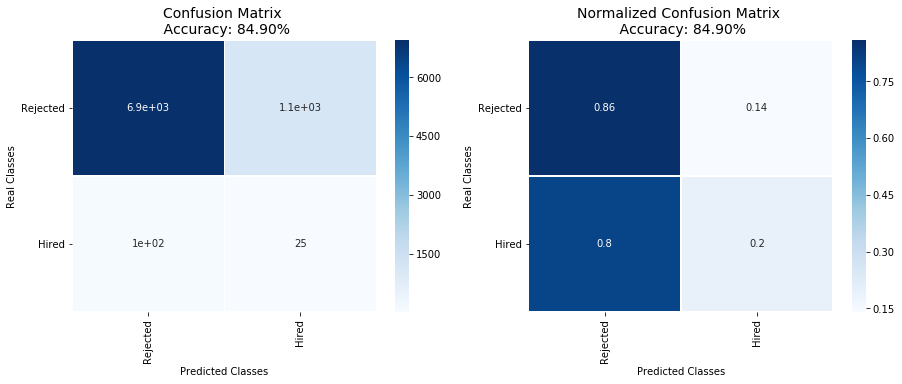

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      8084
           1       0.02      0.20      0.04       127

    accuracy                           0.85      8211
   macro avg       0.50      0.53      0.48      8211
weighted avg       0.97      0.85      0.90      8211



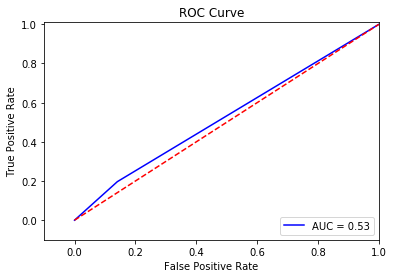

---Weight 60 for the minority class---


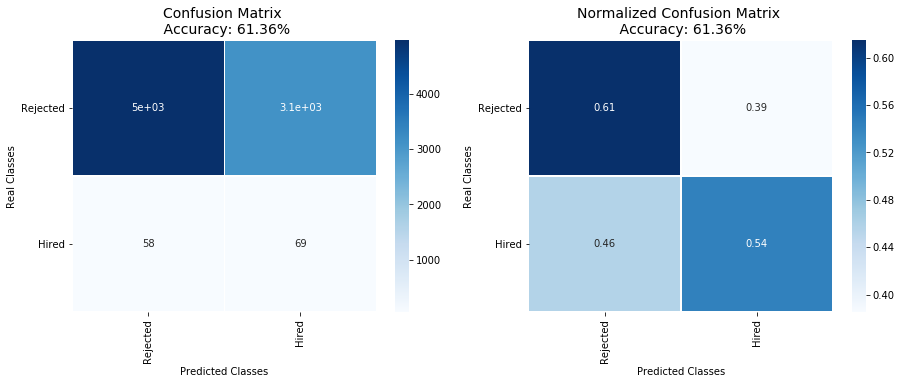

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.61      0.76      8084
           1       0.02      0.54      0.04       127

    accuracy                           0.61      8211
   macro avg       0.51      0.58      0.40      8211
weighted avg       0.97      0.61      0.75      8211



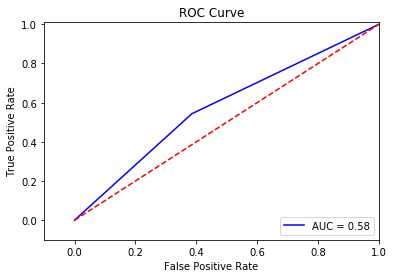

---Weight 70 for the minority class---


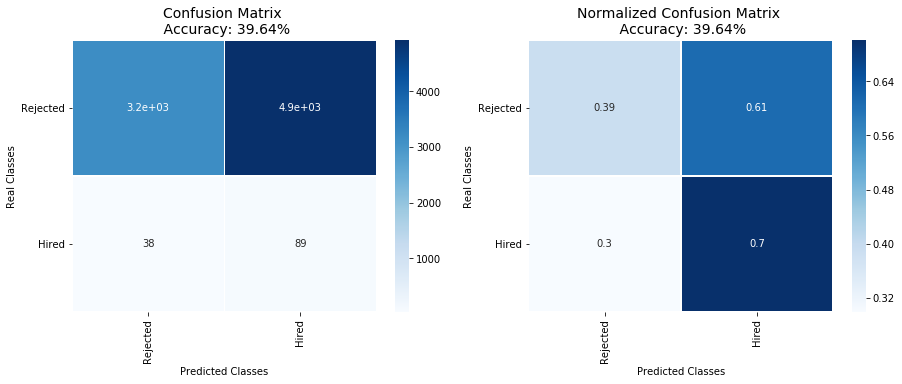

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.39      0.56      8084
           1       0.02      0.70      0.03       127

    accuracy                           0.40      8211
   macro avg       0.50      0.55      0.30      8211
weighted avg       0.97      0.40      0.55      8211



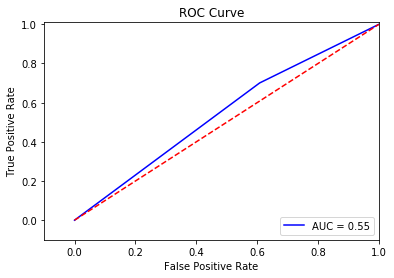

---Weight 80 for the minority class---


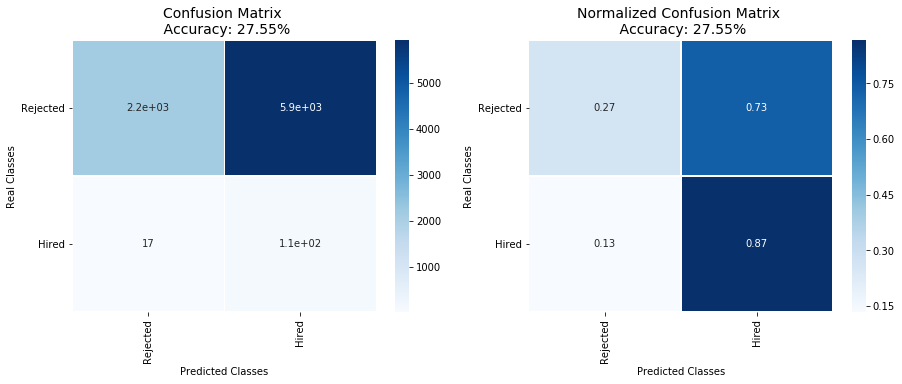

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.27      0.42      8084
           1       0.02      0.87      0.04       127

    accuracy                           0.28      8211
   macro avg       0.51      0.57      0.23      8211
weighted avg       0.98      0.28      0.41      8211



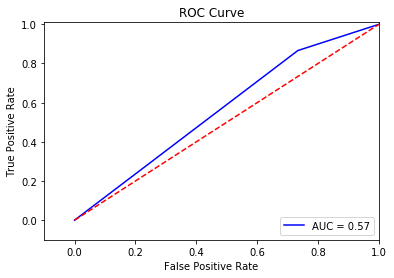

---Weight 90 for the minority class---


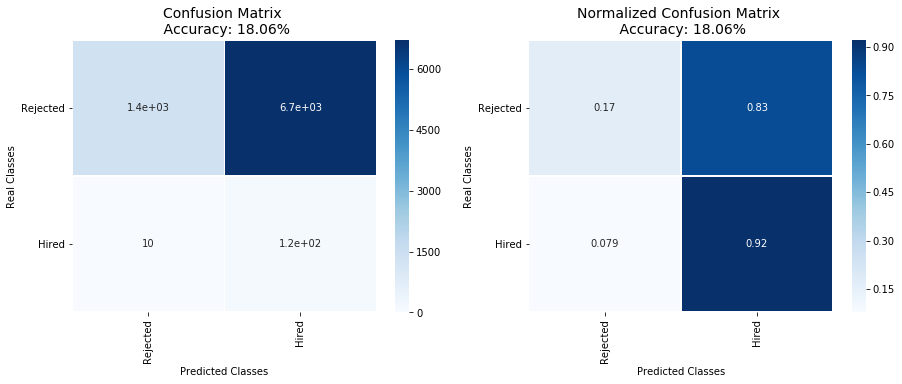

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.17      0.29      8084
           1       0.02      0.92      0.03       127

    accuracy                           0.18      8211
   macro avg       0.50      0.55      0.16      8211
weighted avg       0.98      0.18      0.28      8211



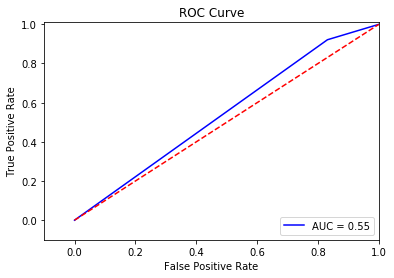

---Weight 100 for the minority class---


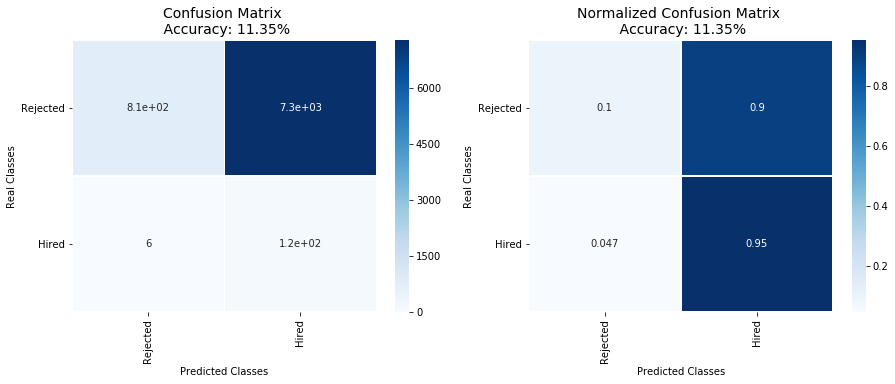

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.10      0.18      8084
           1       0.02      0.95      0.03       127

    accuracy                           0.11      8211
   macro avg       0.50      0.53      0.11      8211
weighted avg       0.98      0.11      0.18      8211



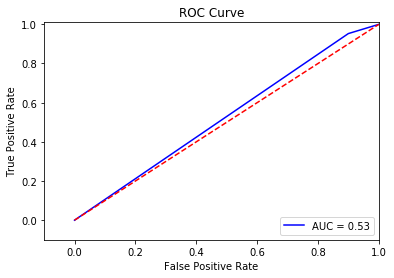

In [36]:
weights = [50 ,60, 70, 80, 90, 100]
for w in weights:
    print('---Weight {} for the minority class---'.format(w))
    lr_model = LogisticRegression(penalty='l1', C=0.01, class_weight={0:1,1:w})
    lr_model.fit(original_Xtrain, original_ytrain)

    cs_pred_lr = lr_model.predict(original_Xtest)
    confusion_matrix_plt(original_ytest, cs_pred_lr)
    
    fpr, tpr, thresholds = roc_curve(original_ytest, cs_pred_lr)
    roc_auc = auc(fpr,tpr)

    # Plot ROC
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [37]:
lr_model = LogisticRegression(penalty='l1', C=0.01, class_weight={0:1,1:60})
lr_model.fit(original_Xtrain, original_ytrain)
cs_pred_lr = lr_model.predict(original_Xtest)

Xtest_lr = Xtest_.copy()
Xtest_lr['Pred'] = cs_pred_lr
Xtest_lr.to_csv('prediction_lr_cs.csv')

In [38]:
# svc_params = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

# svc_cs = RandomizedSearchCV(SVC(), svc_params, n_iter=4)
# svc_cs = svc_cs.fit(original_Xtrain, original_ytrain)

# print('The best parameters are', svc_cs.best_params_)

---Weight of 40 for the minority class---


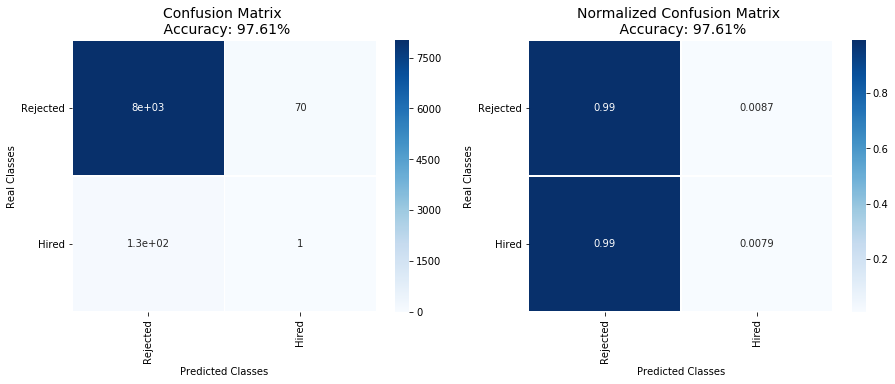

---Classification Report---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8084
           1       0.01      0.01      0.01       127

    accuracy                           0.98      8211
   macro avg       0.50      0.50      0.50      8211
weighted avg       0.97      0.98      0.97      8211



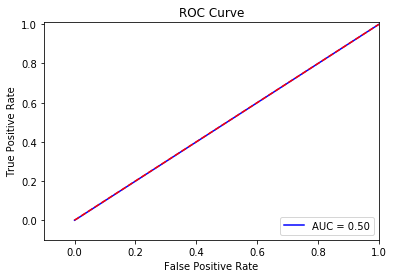

---Weight of 50 for the minority class---


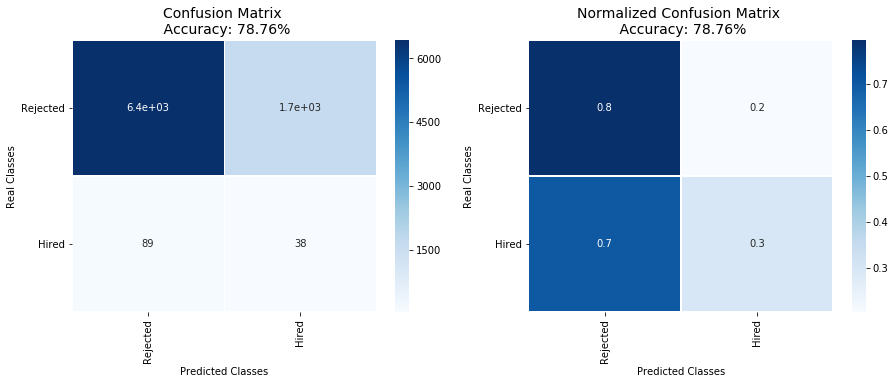

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      8084
           1       0.02      0.30      0.04       127

    accuracy                           0.79      8211
   macro avg       0.50      0.55      0.46      8211
weighted avg       0.97      0.79      0.87      8211



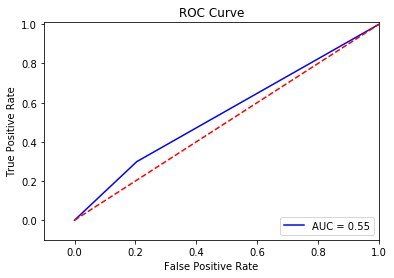

---Weight of 60 for the minority class---


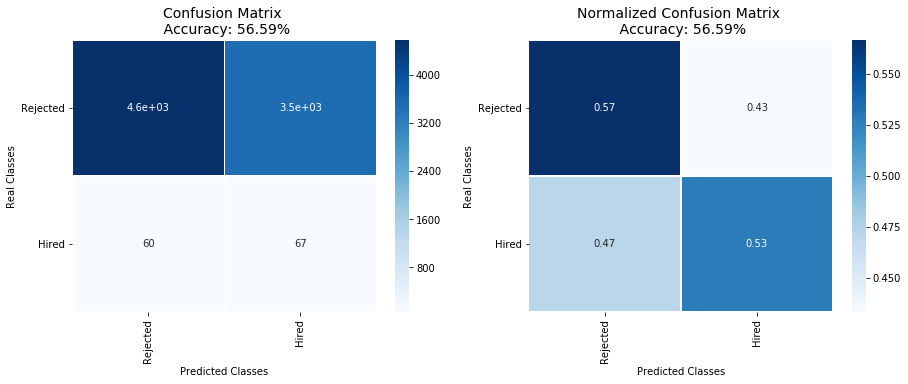

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.57      0.72      8084
           1       0.02      0.53      0.04       127

    accuracy                           0.57      8211
   macro avg       0.50      0.55      0.38      8211
weighted avg       0.97      0.57      0.71      8211



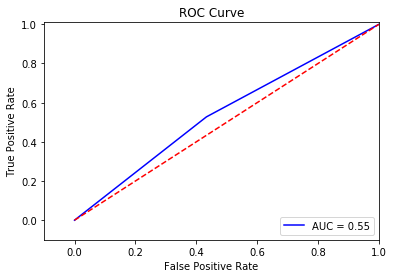

---Weight of 70 for the minority class---


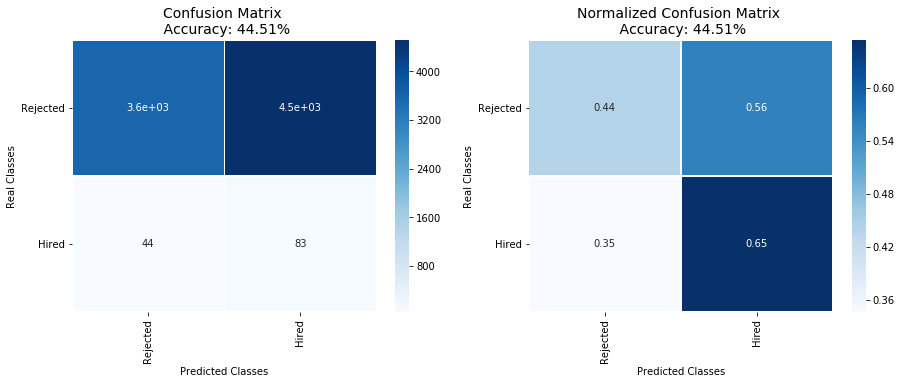

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.44      0.61      8084
           1       0.02      0.65      0.04       127

    accuracy                           0.45      8211
   macro avg       0.50      0.55      0.32      8211
weighted avg       0.97      0.45      0.60      8211



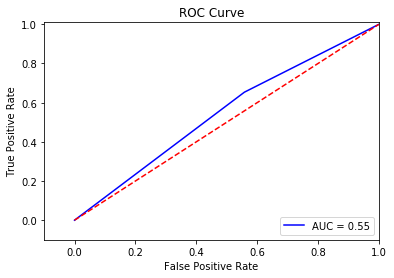

---Weight of 80 for the minority class---


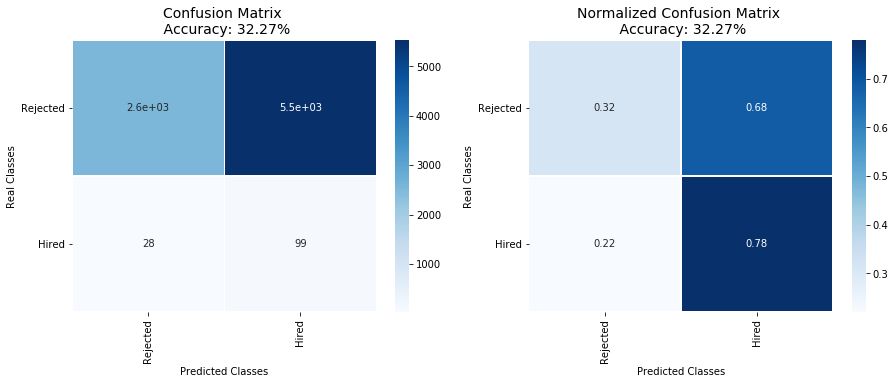

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.32      0.48      8084
           1       0.02      0.78      0.03       127

    accuracy                           0.32      8211
   macro avg       0.50      0.55      0.26      8211
weighted avg       0.97      0.32      0.47      8211



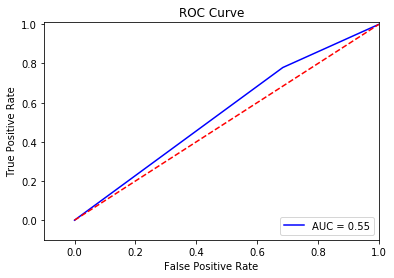

In [39]:
weights = [40, 50, 60, 70, 80]
for w in weights:
    print('---Weight of {} for the minority class---'.format(w))
    svc_model = SVC(kernel='linear', C=10, class_weight={0:1,1:w})
    svc_model.fit(original_Xtrain, original_ytrain)

    cs_pred_svc = svc_model.predict(original_Xtest)
    confusion_matrix_plt(original_ytest, cs_pred_svc)
    
    fpr, tpr, thresholds = roc_curve(original_ytest, cs_pred_svc)
    roc_auc = auc(fpr,tpr)

    # Plot ROC
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [40]:
svc_model = SVC(kernel='linear', C=10, class_weight={0:1,1:60})
svc_model.fit(original_Xtrain, original_ytrain)
cs_pred_svc = svc_model.predict(original_Xtest)

Xtest_svc = Xtest_.copy()
Xtest_svc['Pred'] = cs_pred_svc
Xtest_svc.to_csv('prediction_svc_cs.csv')

In [41]:
# fig = plt.figure(figsize=(15,8))
# ax1 = fig.add_subplot(1,2,1)
# ax1.set_xlim([-0.05,1.05])
# ax1.set_ylim([-0.05,1.05])
# ax1.set_xlabel('Recall')
# ax1.set_ylabel('Precision')
# ax1.set_title('PR Curve')

# ax2 = fig.add_subplot(1,2,2)
# ax2.set_xlim([-0.05,1.05])
# ax2.set_ylim([-0.05,1.05])
# ax2.set_xlabel('False Positive Rate')
# ax2.set_ylabel('True Positive Rate')
# ax2.set_title('ROC Curve')

# for w,k in zip(weights,'bgrcmykw'):
#     lr_model = LogisticRegression(class_weight={0:1,1:w})
#     lr_model.fit(original_Xtrain, original_ytrain)
    
#     pred_prob = lr_model.predict_proba(original_Xtest)[:,1]

#     p,r,_ = precision_recall_curve(original_ytest, pred_prob)
#     tpr,fpr,_ = roc_curve(original_ytest, pred_prob)
    
#     ax1.plot(r,p,c=k,label=w)
#     ax2.plot(tpr,fpr,c=k,label=w)
# ax1.legend(loc='lower left')    
# ax2.legend(loc='lower left')

# plt.show()